El planteamiento es el siguiente:

Los productores de Hollywood  quieren saber cómo el género y la edad de una persona afectan la probabilidad de agradarte o no una película. Los resultados del modelo les dirán a los productores exactamente cómo los cambios en el genero y la edad afectan la probabilidad de que a un individuo determinado le agrade o no una película. Los investigadores también pueden utilizar el modelo de regresión logística para predecir la probabilidad de que a un individuo determinado le agrade o no una película, según la edad y el el género.

Resuelva el planteamiento usando el modelo de regresión logística, genere el planteamiento, identifique las variables, codifiqué la solución, muestre un ejemplo del resultado, finalmente genera una conclusión en base a los resultados obtenidos interpretando el indicador final o la gráfica resultante.

In [2]:
# Se cargan las librerías
library("dplyr")
library("readr")
library("ggplot2")
library("ROCR")

# Lee la información de los archivos
usuarios <- read.table("./movies_data/u.user", header = TRUE, sep = "|")
peliculas <- read.table("./movies_data/u.item", header = TRUE, sep = "|")
calificaciones <- read.table("./movies_data/udata.data", header = TRUE, sep = "\t")

# Se crea una tabla con la información de los usuarios y sus calificaciones
info <- left_join(usuarios, calificaciones, by = "userid", multiple="all")
info <- left_join(info, peliculas, by = "itemid")

# Creamos una columna que nos indique si la película fue calificada como buena o no
info$buena <- ifelse(info$rate >= 4, 1, 0)

Existen más recursos para determinar la correlación de las variables, como la covarianza o una matriz de correlación. Aquí, se usará la librería "corrplot" para graficar este recurso y tener un primer acercamiento a lo solicitado.

corrplot 0.92 loaded



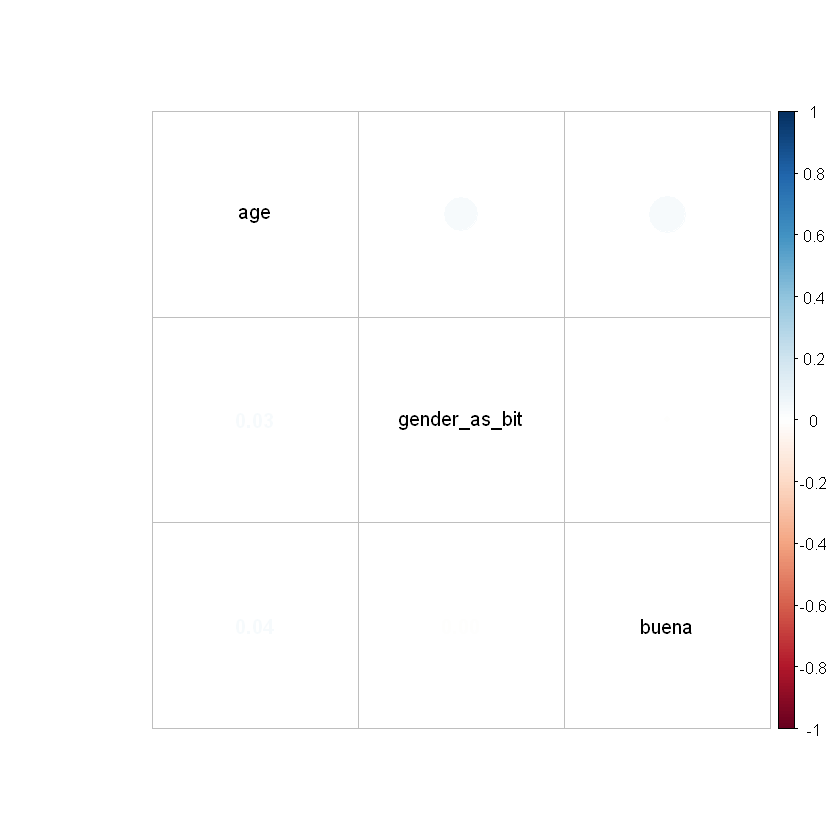

In [3]:
# Cargamos las librerías necesarias para el análisis de correlación
library("corrplot")

# Para poder analizar la correlación entre las variables de edad, género y aceptación en un gráfico,
# es necesario que las variables sean numéricas. Por lo tanto, se codifica el género como 1 para
# masculino y 0 para femenino.

# Se codifica la variable de género
info$gender_as_bit <- ifelse(info$gender == "M", 1, 0)

corrplot.mixed(cor(info[,c("age", "gender_as_bit", "buena")]),tl.col='black')

Primeramente, las variables independientes están dadas desde el planteamiento, que son la edad y el género. Debido a que se realizan cálculos sobre estos datos, es conveniente que el género esté dado como un bit

In [4]:
# Preparamos los datos para el modelo de regresión logística

# Se obtienen los datos de entrenamiento y prueba
set.seed(123)
entrenamiento <- sample(1:nrow(info), 0.8*nrow(info))
prueba <- setdiff(1:nrow(info), entrenamiento)
# Se crea el modelo de regresión logística
modeloRL <- glm(
    buena ~ age + gender_as_bit + itemid,
    data = info[entrenamiento,],
    family = binomial
)
summary(modeloRL)


Call:
glm(formula = buena ~ age + gender_as_bit + itemid, family = binomial, 
    data = info[entrenamiento, ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5795  -1.2540   0.9375   1.0493   1.7006  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    4.447e-01  2.658e-02  16.730   <2e-16 ***
age            6.875e-03  6.264e-04  10.975   <2e-16 ***
gender_as_bit -3.368e-02  1.652e-02  -2.039   0.0414 *  
itemid        -1.008e-03  2.221e-05 -45.406   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 109983  on 79999  degrees of freedom
Residual deviance: 107720  on 79996  degrees of freedom
AIC: 107728

Number of Fisher Scoring iterations: 4


En el análisis, podemos observar los coeficientes de correlación. Debajo de ellos aparece una leyenda, que nos indica que mientras más cerca esté el valor Pr del 0, tiene
una mayor influencia en la variable objetivo.
Esto es, que la edad y la película en concreto influyen en la aceptación que esta tiene (i.e., si es considerada buena o no), mientras que el género tiene poca
influencia en esa determinación.

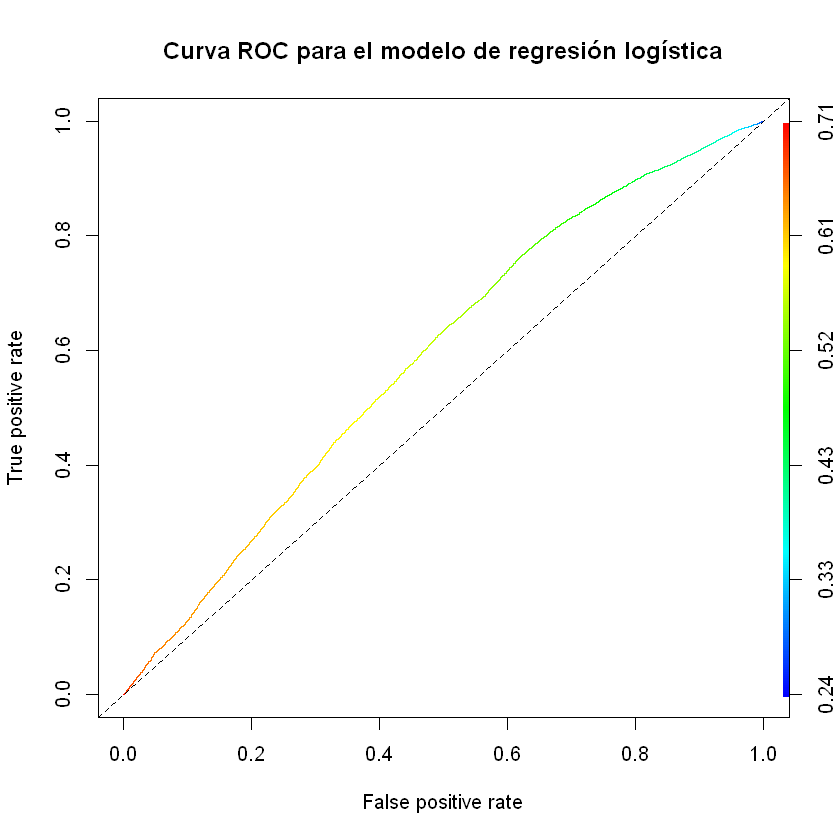

In [7]:
# Se realizan predicciones con el modelo
predicciones <- predict(modeloRL, info[prueba,], type = "response")
# Se usan gráficas ROC para evaluar el modelo
# Empleando la tasa de verdaderos positivos y la tasa de falsos positivos
predicciones_RL <- prediction(predicciones, info[prueba,]$buena)
perf_RL <- performance(predicciones_RL, measure = "tpr", x.measure = "fpr")
plot(perf_RL, colorize = TRUE, main = "Curva ROC para el modelo de regresión logística")
abline(0, 1, lty = 2)

En la gráfica, podemos ver que los umbrales usados varían desde el 0.24 hasta el 0.71.
Para nuestro caso, estamos tomando como valor positivo (como verdadero, o como 1) el hecho de
que una película resulte agradable. Esta gráfica nos informa que, mientras los umbrales varían, se
incrementa la sensibilidad (el porcentaje de películas que serán buenas que el modelo identifica
correctamente, es decir, que predijo que serían bien calificadas y así es en el registro original), pero
también incrementa la tasa de falsos positivos el porcentaje de películas que serán buenas que el
modelo identifica incorrectamente, es decir, que predijo que serían bien calificadas y no así). El punto
óptimo en el que tenemos un balance entre ambas tasas, es alrededor del 50% (0.5)

In [6]:
predicciones <- ifelse(predicciones > 0.5, 1, 0)
# Se crea una matriz de confusión para ver la precisión del algoritmo
tab <- table(predicciones,info[prueba,]$buena)
tab

            
predicciones    0    1
           0 2872 2045
           1 6040 9043

Como podemos observar, 2877 películas se determinaron correctamente como películas que no serían bien aceptadas, a la vez que 9043 fueron correctamente calificadas bajo el criterio de que serán exitosas. Dada la suma de verdaderos positivos y negativos (11915) y el total de registros de prueba (20000), podemos afirmar que nuestro modelo tiene una precisión del 59%

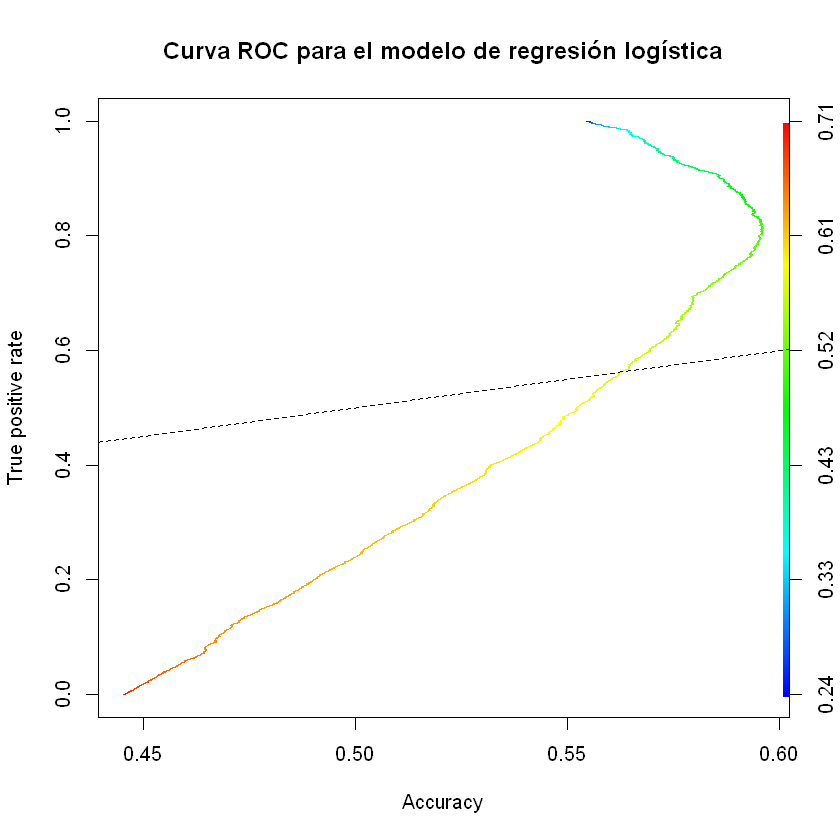

In [8]:
# Empleando la tasa de verdaderos positivos y la precisión
perf_RL <- performance(predicciones_RL, measure = "tpr", x.measure = "acc")
plot(perf_RL, colorize = TRUE, main = "Curva ROC para el modelo de regresión logística")
abline(0, 1, lty = 2)

Como podemos apreciar, la precisión alcanza su límite en el 59%, empleando un umbral de aceptación del 52%, muy similar al que usamos nosotros, y que nos arroja una precisión idéntica a la que obtuvimos al calcularla manualmente usando la matriz de confusión